# Introdução ao Firedrake  

&nbsp;

## Parte 4: Sistema Reativo

&nbsp;

Ministrante: **Diego Tavares Volpatto (LNCC/ESSS)**
&nbsp;

Encontro Acadêmico de Modelagem Computacional - XV EAMC (2022)

<tr>
<td> <img src="../img/logo_eamc.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="../img/banner.png" alt="Drawing" style="width: 550px;"/> </td>
</tr>

## Sumário

Conceitos-chaves:

* Problema transiente
* Múltiplas incógnitas
* Não-linear
* Em resumo: Problema transiente, misto e não-linear (tudo que vimos)

# Modelo de Gray-Scott

## Modelo

É um para reatores de gel auto-catalisados e que formam padrões interessantes para as concentrações ao longo do tempo. É composto por duas equações:

\begin{equation}
\begin{aligned}
&\frac{\partial u}{\partial t}=\Delta u -u v^{2}+A(1-u) \\
&\frac{\partial v}{\partial t}=\delta^{2} \Delta v + u v^{2}-B v
\end{aligned}
\end{equation}

Consideraremos aqui apenas o caso 1D. O estudo que faremos é baseado [neste artigo](https://www.sciencedirect.com/science/article/pii/S0022247X15007957?via%3Dihub).

## Forma Fraca

Cada equação é "testada" por sua respectiva função-teste. Dessa forma:

\begin{equation}
\begin{aligned}
&\left(\dfrac{u - u_0}{\Delta t}, p\right)_\Omega = -(\nabla u, \nabla p)_\Omega - (u v^{2}, p)_\Omega + (A(1-u), p)_\Omega \\
&\left(\dfrac{v - v_0}{\Delta t}, q\right)_\Omega = -(\delta^{2} \nabla v, \nabla q)_\Omega + (u v^{2}, q)_\Omega - (B v, q)_\Omega
\end{aligned}
\end{equation}

Com os pares {candidato, teste}:

* $\{u, p\}$
* $\{v, q\}$

Discretização no tempo: Euler Implícito, e $u_0$ e $v_0$ sempre vão representar a solução no passo de tempo anterior, para não carregar notação.

# Implementação

## Considerações

O setup geral é baseado no artigo de referência. O objetivo é reproduzir a Fig. 3d do artigo.

## Importando as libs

In [1]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

plt.style.use(['seaborn-poster'])

## Definição da geometria

A configuração é fortemente baseada no artigo. Verifique a Seção 4.2 para detalhes.

In [2]:
num_elements = 800
L = 100.0
x_left, x_right = 0.0, L
mesh = IntervalMesh(num_elements, x_left, x_right)
x = mesh.coordinates

## Espaço de Funções

Temos um problema misto e não-linear. Por conta da não-linearidade, vamos utilizar um polinômio de mais alta ordem.

In [3]:
degree = 3
V = FunctionSpace(mesh, "CG", degree)
W = V * V
Vref = FunctionSpace(mesh, "CG", 1)  # para plotar sobre a malha

## Funções do problema

Seguindo as funções utilizadas na forma fraca:

In [4]:
w = Function(W)
u, v = split(w)  # recupera funções no espaço misto
p, q = TestFunction(W)

## Condições Iniciais

Adotaremos as mesmas utilizadas no artigo:

\begin{equation}
u(x, 0)=1-0.5 \sin ^{100}(\pi x / L)
\end{equation}

\begin{equation}
v(x, 0)=0.25 \sin ^{100}(\pi x / L)
\end{equation}

Portanto:

In [5]:
w0 = Function(W)
u0, v0 = w0.split()
u0.interpolate(1 - (1. / 2.) * sin(pi * x[0] / L) ** 100.)
v0.interpolate((1. / 4.) * sin(pi * x[0] / L) ** 100.)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fce979c8eb0>, FiniteElement('Lagrange', interval, 3), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 9)

## Condições de Contorno essenciais

Compatíveis com as CI e coletadas do artigo:

In [6]:
boundary_value_u = 1.0
boundary_value_v = 0.0
u_bc = DirichletBC(W.sub(0), boundary_value_u, "on_boundary")
v_bc = DirichletBC(W.sub(1), boundary_value_v, "on_boundary")

## Parâmetros do Modelo

Também coletados do artigo (para o caso de interesse):

In [7]:
delta_squared = Constant(0.01)
A = Constant(0.01)
B = Constant(0.053)

## Parâmetros temporais

Para a evolução no tempo:

In [8]:
Total_time = 4000.
dt = 1.0
Dt = Constant(dt)

Note que o artigo utiliza `dt = 0.5`.

## Formulação Variacional

### Forma Fraca

\begin{equation}
\begin{aligned}
&\left(\dfrac{u - u_0}{\Delta t}, p\right)_\Omega = -(\nabla u, \nabla p)_\Omega - (u v^{2}, p)_\Omega + (A(1-u), p)_\Omega \\
&\left(\dfrac{v - v_0}{\Delta t}, q\right)_\Omega = -(\delta^{2} \nabla v, \nabla q)_\Omega + (u v^{2}, q)_\Omega - (B v, q)_\Omega
\end{aligned}
\end{equation}

### Implementação

In [9]:
# ** U part **
F = inner((u - u0) / Dt, p) * dx + inner(grad(u), grad(p)) * dx + u * v * v * p * dx - A * (1.0 - u) * p * dx
# ** V part **
F += inner((v - v0) / Dt, q) * dx + inner(delta_squared * grad(v), grad(q)) * dx - u * v * v * q * dx + B * v * q * dx

## Problema Variacional e Inicialização do Solver

Mesmo procedimento para o que vimos na Eq. do Calor:

In [10]:
solver_parameters = {
    'mat_type': 'aij',
    'snes_tyoe': 'newtonls',
    'pc_type': 'lu'
}
problem = NonlinearVariationalProblem(F, w)
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

## Iterando no tempo

Vamos definir algumas quantidades para armazenar nossas soluções:

In [11]:
u_values = []
v_values = []
u_values_deg1 = []
v_values_deg1 = []

Algumas quantidades auxiliares:

In [12]:
usol_deg1 = Function(Vref)  # para plotar sobre a malha
vsol_deg1 = Function(Vref)
x_values = mesh.coordinates.vector().dat.data

Por fim, o laço no tempo:

In [13]:
step = 0
t = 0.0
while t < Total_time:
    step += 1
    print('============================')
    print(f'\ttime = {t:.3e}')
    print(f'\tstep = {step}')
    print('============================')

    solver.solve()
    w0.assign(w)

    usol, vsol = w.split()  # a solução no passo de tempo
    
    # Projeções auxiliares
    usol_deg1.project(usol)
    vsol_deg1.project(vsol)
    
    # Armazenamentos
    u_vec = np.array(usol.vector().dat.data)
    u_values.append(u_vec)
    
    u_vec_deg1 = np.array(usol_deg1.vector().dat.data)
    u_values_deg1.append(u_vec_deg1)
    
    v_vec = np.array(vsol.vector().dat.data)
    v_values.append(v_vec)
    
    v_vec_deg1 = np.array(vsol_deg1.vector().dat.data)
    v_values_deg1.append(v_vec_deg1)

    t += dt

	time = 0.000e+00
	step = 1
	time = 1.000e+00
	step = 2
	time = 2.000e+00
	step = 3
	time = 3.000e+00
	step = 4
	time = 4.000e+00
	step = 5
	time = 5.000e+00
	step = 6
	time = 6.000e+00
	step = 7
	time = 7.000e+00
	step = 8
	time = 8.000e+00
	step = 9
	time = 9.000e+00
	step = 10
	time = 1.000e+01
	step = 11
	time = 1.100e+01
	step = 12
	time = 1.200e+01
	step = 13
	time = 1.300e+01
	step = 14
	time = 1.400e+01
	step = 15
	time = 1.500e+01
	step = 16
	time = 1.600e+01
	step = 17
	time = 1.700e+01
	step = 18
	time = 1.800e+01
	step = 19
	time = 1.900e+01
	step = 20
	time = 2.000e+01
	step = 21
	time = 2.100e+01
	step = 22
	time = 2.200e+01
	step = 23
	time = 2.300e+01
	step = 24
	time = 2.400e+01
	step = 25
	time = 2.500e+01
	step = 26
	time = 2.600e+01
	step = 27
	time = 2.700e+01
	step = 28
	time = 2.800e+01
	step = 29
	time = 2.900e+01
	step = 30
	time = 3.000e+01
	step = 31
	time = 3.100e+01
	step = 32
	time = 3.200e+01
	step = 33
	time = 3.300e+01
	step = 34
	time = 3.400e+01
	step

	time = 1.060e+02
	step = 107
	time = 1.070e+02
	step = 108
	time = 1.080e+02
	step = 109
	time = 1.090e+02
	step = 110
	time = 1.100e+02
	step = 111
	time = 1.110e+02
	step = 112
	time = 1.120e+02
	step = 113
	time = 1.130e+02
	step = 114
	time = 1.140e+02
	step = 115
	time = 1.150e+02
	step = 116
	time = 1.160e+02
	step = 117
	time = 1.170e+02
	step = 118
	time = 1.180e+02
	step = 119
	time = 1.190e+02
	step = 120
	time = 1.200e+02
	step = 121
	time = 1.210e+02
	step = 122
	time = 1.220e+02
	step = 123
	time = 1.230e+02
	step = 124
	time = 1.240e+02
	step = 125
	time = 1.250e+02
	step = 126
	time = 1.260e+02
	step = 127
	time = 1.270e+02
	step = 128
	time = 1.280e+02
	step = 129
	time = 1.290e+02
	step = 130
	time = 1.300e+02
	step = 131
	time = 1.310e+02
	step = 132
	time = 1.320e+02
	step = 133
	time = 1.330e+02
	step = 134
	time = 1.340e+02
	step = 135
	time = 1.350e+02
	step = 136
	time = 1.360e+02
	step = 137
	time = 1.370e+02
	step = 138
	time = 1.380e+02
	step = 139
	time = 1.

	time = 2.060e+02
	step = 207
	time = 2.070e+02
	step = 208
	time = 2.080e+02
	step = 209
	time = 2.090e+02
	step = 210
	time = 2.100e+02
	step = 211
	time = 2.110e+02
	step = 212
	time = 2.120e+02
	step = 213
	time = 2.130e+02
	step = 214
	time = 2.140e+02
	step = 215
	time = 2.150e+02
	step = 216
	time = 2.160e+02
	step = 217
	time = 2.170e+02
	step = 218
	time = 2.180e+02
	step = 219
	time = 2.190e+02
	step = 220
	time = 2.200e+02
	step = 221
	time = 2.210e+02
	step = 222
	time = 2.220e+02
	step = 223
	time = 2.230e+02
	step = 224
	time = 2.240e+02
	step = 225
	time = 2.250e+02
	step = 226
	time = 2.260e+02
	step = 227
	time = 2.270e+02
	step = 228
	time = 2.280e+02
	step = 229
	time = 2.290e+02
	step = 230
	time = 2.300e+02
	step = 231
	time = 2.310e+02
	step = 232
	time = 2.320e+02
	step = 233
	time = 2.330e+02
	step = 234
	time = 2.340e+02
	step = 235
	time = 2.350e+02
	step = 236
	time = 2.360e+02
	step = 237
	time = 2.370e+02
	step = 238
	time = 2.380e+02
	step = 239
	time = 2.

	time = 3.010e+02
	step = 302
	time = 3.020e+02
	step = 303
	time = 3.030e+02
	step = 304
	time = 3.040e+02
	step = 305
	time = 3.050e+02
	step = 306
	time = 3.060e+02
	step = 307
	time = 3.070e+02
	step = 308
	time = 3.080e+02
	step = 309
	time = 3.090e+02
	step = 310
	time = 3.100e+02
	step = 311
	time = 3.110e+02
	step = 312
	time = 3.120e+02
	step = 313
	time = 3.130e+02
	step = 314
	time = 3.140e+02
	step = 315
	time = 3.150e+02
	step = 316
	time = 3.160e+02
	step = 317
	time = 3.170e+02
	step = 318
	time = 3.180e+02
	step = 319
	time = 3.190e+02
	step = 320
	time = 3.200e+02
	step = 321
	time = 3.210e+02
	step = 322
	time = 3.220e+02
	step = 323
	time = 3.230e+02
	step = 324
	time = 3.240e+02
	step = 325
	time = 3.250e+02
	step = 326
	time = 3.260e+02
	step = 327
	time = 3.270e+02
	step = 328
	time = 3.280e+02
	step = 329
	time = 3.290e+02
	step = 330
	time = 3.300e+02
	step = 331
	time = 3.310e+02
	step = 332
	time = 3.320e+02
	step = 333
	time = 3.330e+02
	step = 334
	time = 3.

	time = 3.950e+02
	step = 396
	time = 3.960e+02
	step = 397
	time = 3.970e+02
	step = 398
	time = 3.980e+02
	step = 399
	time = 3.990e+02
	step = 400
	time = 4.000e+02
	step = 401
	time = 4.010e+02
	step = 402
	time = 4.020e+02
	step = 403
	time = 4.030e+02
	step = 404
	time = 4.040e+02
	step = 405
	time = 4.050e+02
	step = 406
	time = 4.060e+02
	step = 407
	time = 4.070e+02
	step = 408
	time = 4.080e+02
	step = 409
	time = 4.090e+02
	step = 410
	time = 4.100e+02
	step = 411
	time = 4.110e+02
	step = 412
	time = 4.120e+02
	step = 413
	time = 4.130e+02
	step = 414
	time = 4.140e+02
	step = 415
	time = 4.150e+02
	step = 416
	time = 4.160e+02
	step = 417
	time = 4.170e+02
	step = 418
	time = 4.180e+02
	step = 419
	time = 4.190e+02
	step = 420
	time = 4.200e+02
	step = 421
	time = 4.210e+02
	step = 422
	time = 4.220e+02
	step = 423
	time = 4.230e+02
	step = 424
	time = 4.240e+02
	step = 425
	time = 4.250e+02
	step = 426
	time = 4.260e+02
	step = 427
	time = 4.270e+02
	step = 428
	time = 4.

	time = 4.940e+02
	step = 495
	time = 4.950e+02
	step = 496
	time = 4.960e+02
	step = 497
	time = 4.970e+02
	step = 498
	time = 4.980e+02
	step = 499
	time = 4.990e+02
	step = 500
	time = 5.000e+02
	step = 501
	time = 5.010e+02
	step = 502
	time = 5.020e+02
	step = 503
	time = 5.030e+02
	step = 504
	time = 5.040e+02
	step = 505
	time = 5.050e+02
	step = 506
	time = 5.060e+02
	step = 507
	time = 5.070e+02
	step = 508
	time = 5.080e+02
	step = 509
	time = 5.090e+02
	step = 510
	time = 5.100e+02
	step = 511
	time = 5.110e+02
	step = 512
	time = 5.120e+02
	step = 513
	time = 5.130e+02
	step = 514
	time = 5.140e+02
	step = 515
	time = 5.150e+02
	step = 516
	time = 5.160e+02
	step = 517
	time = 5.170e+02
	step = 518
	time = 5.180e+02
	step = 519
	time = 5.190e+02
	step = 520
	time = 5.200e+02
	step = 521
	time = 5.210e+02
	step = 522
	time = 5.220e+02
	step = 523
	time = 5.230e+02
	step = 524
	time = 5.240e+02
	step = 525
	time = 5.250e+02
	step = 526
	time = 5.260e+02
	step = 527
	time = 5.

	time = 5.970e+02
	step = 598
	time = 5.980e+02
	step = 599
	time = 5.990e+02
	step = 600
	time = 6.000e+02
	step = 601
	time = 6.010e+02
	step = 602
	time = 6.020e+02
	step = 603
	time = 6.030e+02
	step = 604
	time = 6.040e+02
	step = 605
	time = 6.050e+02
	step = 606
	time = 6.060e+02
	step = 607
	time = 6.070e+02
	step = 608
	time = 6.080e+02
	step = 609
	time = 6.090e+02
	step = 610
	time = 6.100e+02
	step = 611
	time = 6.110e+02
	step = 612
	time = 6.120e+02
	step = 613
	time = 6.130e+02
	step = 614
	time = 6.140e+02
	step = 615
	time = 6.150e+02
	step = 616
	time = 6.160e+02
	step = 617
	time = 6.170e+02
	step = 618
	time = 6.180e+02
	step = 619
	time = 6.190e+02
	step = 620
	time = 6.200e+02
	step = 621
	time = 6.210e+02
	step = 622
	time = 6.220e+02
	step = 623
	time = 6.230e+02
	step = 624
	time = 6.240e+02
	step = 625
	time = 6.250e+02
	step = 626
	time = 6.260e+02
	step = 627
	time = 6.270e+02
	step = 628
	time = 6.280e+02
	step = 629
	time = 6.290e+02
	step = 630
	time = 6.

	time = 6.910e+02
	step = 692
	time = 6.920e+02
	step = 693
	time = 6.930e+02
	step = 694
	time = 6.940e+02
	step = 695
	time = 6.950e+02
	step = 696
	time = 6.960e+02
	step = 697
	time = 6.970e+02
	step = 698
	time = 6.980e+02
	step = 699
	time = 6.990e+02
	step = 700
	time = 7.000e+02
	step = 701
	time = 7.010e+02
	step = 702
	time = 7.020e+02
	step = 703
	time = 7.030e+02
	step = 704
	time = 7.040e+02
	step = 705
	time = 7.050e+02
	step = 706
	time = 7.060e+02
	step = 707
	time = 7.070e+02
	step = 708
	time = 7.080e+02
	step = 709
	time = 7.090e+02
	step = 710
	time = 7.100e+02
	step = 711
	time = 7.110e+02
	step = 712
	time = 7.120e+02
	step = 713
	time = 7.130e+02
	step = 714
	time = 7.140e+02
	step = 715
	time = 7.150e+02
	step = 716
	time = 7.160e+02
	step = 717
	time = 7.170e+02
	step = 718
	time = 7.180e+02
	step = 719
	time = 7.190e+02
	step = 720
	time = 7.200e+02
	step = 721
	time = 7.210e+02
	step = 722
	time = 7.220e+02
	step = 723
	time = 7.230e+02
	step = 724
	time = 7.

	time = 7.890e+02
	step = 790
	time = 7.900e+02
	step = 791
	time = 7.910e+02
	step = 792
	time = 7.920e+02
	step = 793
	time = 7.930e+02
	step = 794
	time = 7.940e+02
	step = 795
	time = 7.950e+02
	step = 796
	time = 7.960e+02
	step = 797
	time = 7.970e+02
	step = 798
	time = 7.980e+02
	step = 799
	time = 7.990e+02
	step = 800
	time = 8.000e+02
	step = 801
	time = 8.010e+02
	step = 802
	time = 8.020e+02
	step = 803
	time = 8.030e+02
	step = 804
	time = 8.040e+02
	step = 805
	time = 8.050e+02
	step = 806
	time = 8.060e+02
	step = 807
	time = 8.070e+02
	step = 808
	time = 8.080e+02
	step = 809
	time = 8.090e+02
	step = 810
	time = 8.100e+02
	step = 811
	time = 8.110e+02
	step = 812
	time = 8.120e+02
	step = 813
	time = 8.130e+02
	step = 814
	time = 8.140e+02
	step = 815
	time = 8.150e+02
	step = 816
	time = 8.160e+02
	step = 817
	time = 8.170e+02
	step = 818
	time = 8.180e+02
	step = 819
	time = 8.190e+02
	step = 820
	time = 8.200e+02
	step = 821
	time = 8.210e+02
	step = 822
	time = 8.

	time = 8.950e+02
	step = 896
	time = 8.960e+02
	step = 897
	time = 8.970e+02
	step = 898
	time = 8.980e+02
	step = 899
	time = 8.990e+02
	step = 900
	time = 9.000e+02
	step = 901
	time = 9.010e+02
	step = 902
	time = 9.020e+02
	step = 903
	time = 9.030e+02
	step = 904
	time = 9.040e+02
	step = 905
	time = 9.050e+02
	step = 906
	time = 9.060e+02
	step = 907
	time = 9.070e+02
	step = 908
	time = 9.080e+02
	step = 909
	time = 9.090e+02
	step = 910
	time = 9.100e+02
	step = 911
	time = 9.110e+02
	step = 912
	time = 9.120e+02
	step = 913
	time = 9.130e+02
	step = 914
	time = 9.140e+02
	step = 915
	time = 9.150e+02
	step = 916
	time = 9.160e+02
	step = 917
	time = 9.170e+02
	step = 918
	time = 9.180e+02
	step = 919
	time = 9.190e+02
	step = 920
	time = 9.200e+02
	step = 921
	time = 9.210e+02
	step = 922
	time = 9.220e+02
	step = 923
	time = 9.230e+02
	step = 924
	time = 9.240e+02
	step = 925
	time = 9.250e+02
	step = 926
	time = 9.260e+02
	step = 927
	time = 9.270e+02
	step = 928
	time = 9.

	time = 9.920e+02
	step = 993
	time = 9.930e+02
	step = 994
	time = 9.940e+02
	step = 995
	time = 9.950e+02
	step = 996
	time = 9.960e+02
	step = 997
	time = 9.970e+02
	step = 998
	time = 9.980e+02
	step = 999
	time = 9.990e+02
	step = 1000
	time = 1.000e+03
	step = 1001
	time = 1.001e+03
	step = 1002
	time = 1.002e+03
	step = 1003
	time = 1.003e+03
	step = 1004
	time = 1.004e+03
	step = 1005
	time = 1.005e+03
	step = 1006
	time = 1.006e+03
	step = 1007
	time = 1.007e+03
	step = 1008
	time = 1.008e+03
	step = 1009
	time = 1.009e+03
	step = 1010
	time = 1.010e+03
	step = 1011
	time = 1.011e+03
	step = 1012
	time = 1.012e+03
	step = 1013
	time = 1.013e+03
	step = 1014
	time = 1.014e+03
	step = 1015
	time = 1.015e+03
	step = 1016
	time = 1.016e+03
	step = 1017
	time = 1.017e+03
	step = 1018
	time = 1.018e+03
	step = 1019
	time = 1.019e+03
	step = 1020
	time = 1.020e+03
	step = 1021
	time = 1.021e+03
	step = 1022
	time = 1.022e+03
	step = 1023
	time = 1.023e+03
	step = 1024
	time = 1.024e+

	time = 1.087e+03
	step = 1088
	time = 1.088e+03
	step = 1089
	time = 1.089e+03
	step = 1090
	time = 1.090e+03
	step = 1091
	time = 1.091e+03
	step = 1092
	time = 1.092e+03
	step = 1093
	time = 1.093e+03
	step = 1094
	time = 1.094e+03
	step = 1095
	time = 1.095e+03
	step = 1096
	time = 1.096e+03
	step = 1097
	time = 1.097e+03
	step = 1098
	time = 1.098e+03
	step = 1099
	time = 1.099e+03
	step = 1100
	time = 1.100e+03
	step = 1101
	time = 1.101e+03
	step = 1102
	time = 1.102e+03
	step = 1103
	time = 1.103e+03
	step = 1104
	time = 1.104e+03
	step = 1105
	time = 1.105e+03
	step = 1106
	time = 1.106e+03
	step = 1107
	time = 1.107e+03
	step = 1108
	time = 1.108e+03
	step = 1109
	time = 1.109e+03
	step = 1110
	time = 1.110e+03
	step = 1111
	time = 1.111e+03
	step = 1112
	time = 1.112e+03
	step = 1113
	time = 1.113e+03
	step = 1114
	time = 1.114e+03
	step = 1115
	time = 1.115e+03
	step = 1116
	time = 1.116e+03
	step = 1117
	time = 1.117e+03
	step = 1118
	time = 1.118e+03
	step = 1119
	time = 

	time = 1.189e+03
	step = 1190
	time = 1.190e+03
	step = 1191
	time = 1.191e+03
	step = 1192
	time = 1.192e+03
	step = 1193
	time = 1.193e+03
	step = 1194
	time = 1.194e+03
	step = 1195
	time = 1.195e+03
	step = 1196
	time = 1.196e+03
	step = 1197
	time = 1.197e+03
	step = 1198
	time = 1.198e+03
	step = 1199
	time = 1.199e+03
	step = 1200
	time = 1.200e+03
	step = 1201
	time = 1.201e+03
	step = 1202
	time = 1.202e+03
	step = 1203
	time = 1.203e+03
	step = 1204
	time = 1.204e+03
	step = 1205
	time = 1.205e+03
	step = 1206
	time = 1.206e+03
	step = 1207
	time = 1.207e+03
	step = 1208
	time = 1.208e+03
	step = 1209
	time = 1.209e+03
	step = 1210
	time = 1.210e+03
	step = 1211
	time = 1.211e+03
	step = 1212
	time = 1.212e+03
	step = 1213
	time = 1.213e+03
	step = 1214
	time = 1.214e+03
	step = 1215
	time = 1.215e+03
	step = 1216
	time = 1.216e+03
	step = 1217
	time = 1.217e+03
	step = 1218
	time = 1.218e+03
	step = 1219
	time = 1.219e+03
	step = 1220
	time = 1.220e+03
	step = 1221
	time = 

	time = 1.292e+03
	step = 1293
	time = 1.293e+03
	step = 1294
	time = 1.294e+03
	step = 1295
	time = 1.295e+03
	step = 1296
	time = 1.296e+03
	step = 1297
	time = 1.297e+03
	step = 1298
	time = 1.298e+03
	step = 1299
	time = 1.299e+03
	step = 1300
	time = 1.300e+03
	step = 1301
	time = 1.301e+03
	step = 1302
	time = 1.302e+03
	step = 1303
	time = 1.303e+03
	step = 1304
	time = 1.304e+03
	step = 1305
	time = 1.305e+03
	step = 1306
	time = 1.306e+03
	step = 1307
	time = 1.307e+03
	step = 1308
	time = 1.308e+03
	step = 1309
	time = 1.309e+03
	step = 1310
	time = 1.310e+03
	step = 1311
	time = 1.311e+03
	step = 1312
	time = 1.312e+03
	step = 1313
	time = 1.313e+03
	step = 1314
	time = 1.314e+03
	step = 1315
	time = 1.315e+03
	step = 1316
	time = 1.316e+03
	step = 1317
	time = 1.317e+03
	step = 1318
	time = 1.318e+03
	step = 1319
	time = 1.319e+03
	step = 1320
	time = 1.320e+03
	step = 1321
	time = 1.321e+03
	step = 1322
	time = 1.322e+03
	step = 1323
	time = 1.323e+03
	step = 1324
	time = 

	time = 1.393e+03
	step = 1394
	time = 1.394e+03
	step = 1395
	time = 1.395e+03
	step = 1396
	time = 1.396e+03
	step = 1397
	time = 1.397e+03
	step = 1398
	time = 1.398e+03
	step = 1399
	time = 1.399e+03
	step = 1400
	time = 1.400e+03
	step = 1401
	time = 1.401e+03
	step = 1402
	time = 1.402e+03
	step = 1403
	time = 1.403e+03
	step = 1404
	time = 1.404e+03
	step = 1405
	time = 1.405e+03
	step = 1406
	time = 1.406e+03
	step = 1407
	time = 1.407e+03
	step = 1408
	time = 1.408e+03
	step = 1409
	time = 1.409e+03
	step = 1410
	time = 1.410e+03
	step = 1411
	time = 1.411e+03
	step = 1412
	time = 1.412e+03
	step = 1413
	time = 1.413e+03
	step = 1414
	time = 1.414e+03
	step = 1415
	time = 1.415e+03
	step = 1416
	time = 1.416e+03
	step = 1417
	time = 1.417e+03
	step = 1418
	time = 1.418e+03
	step = 1419
	time = 1.419e+03
	step = 1420
	time = 1.420e+03
	step = 1421
	time = 1.421e+03
	step = 1422
	time = 1.422e+03
	step = 1423
	time = 1.423e+03
	step = 1424
	time = 1.424e+03
	step = 1425
	time = 

	time = 1.489e+03
	step = 1490
	time = 1.490e+03
	step = 1491
	time = 1.491e+03
	step = 1492
	time = 1.492e+03
	step = 1493
	time = 1.493e+03
	step = 1494
	time = 1.494e+03
	step = 1495
	time = 1.495e+03
	step = 1496
	time = 1.496e+03
	step = 1497
	time = 1.497e+03
	step = 1498
	time = 1.498e+03
	step = 1499
	time = 1.499e+03
	step = 1500
	time = 1.500e+03
	step = 1501
	time = 1.501e+03
	step = 1502
	time = 1.502e+03
	step = 1503
	time = 1.503e+03
	step = 1504
	time = 1.504e+03
	step = 1505
	time = 1.505e+03
	step = 1506
	time = 1.506e+03
	step = 1507
	time = 1.507e+03
	step = 1508
	time = 1.508e+03
	step = 1509
	time = 1.509e+03
	step = 1510
	time = 1.510e+03
	step = 1511
	time = 1.511e+03
	step = 1512
	time = 1.512e+03
	step = 1513
	time = 1.513e+03
	step = 1514
	time = 1.514e+03
	step = 1515
	time = 1.515e+03
	step = 1516
	time = 1.516e+03
	step = 1517
	time = 1.517e+03
	step = 1518
	time = 1.518e+03
	step = 1519
	time = 1.519e+03
	step = 1520
	time = 1.520e+03
	step = 1521
	time = 

	time = 1.590e+03
	step = 1591
	time = 1.591e+03
	step = 1592
	time = 1.592e+03
	step = 1593
	time = 1.593e+03
	step = 1594
	time = 1.594e+03
	step = 1595
	time = 1.595e+03
	step = 1596
	time = 1.596e+03
	step = 1597
	time = 1.597e+03
	step = 1598
	time = 1.598e+03
	step = 1599
	time = 1.599e+03
	step = 1600
	time = 1.600e+03
	step = 1601
	time = 1.601e+03
	step = 1602
	time = 1.602e+03
	step = 1603
	time = 1.603e+03
	step = 1604
	time = 1.604e+03
	step = 1605
	time = 1.605e+03
	step = 1606
	time = 1.606e+03
	step = 1607
	time = 1.607e+03
	step = 1608
	time = 1.608e+03
	step = 1609
	time = 1.609e+03
	step = 1610
	time = 1.610e+03
	step = 1611
	time = 1.611e+03
	step = 1612
	time = 1.612e+03
	step = 1613
	time = 1.613e+03
	step = 1614
	time = 1.614e+03
	step = 1615
	time = 1.615e+03
	step = 1616
	time = 1.616e+03
	step = 1617
	time = 1.617e+03
	step = 1618
	time = 1.618e+03
	step = 1619
	time = 1.619e+03
	step = 1620
	time = 1.620e+03
	step = 1621
	time = 1.621e+03
	step = 1622
	time = 

	time = 1.691e+03
	step = 1692
	time = 1.692e+03
	step = 1693
	time = 1.693e+03
	step = 1694
	time = 1.694e+03
	step = 1695
	time = 1.695e+03
	step = 1696
	time = 1.696e+03
	step = 1697
	time = 1.697e+03
	step = 1698
	time = 1.698e+03
	step = 1699
	time = 1.699e+03
	step = 1700
	time = 1.700e+03
	step = 1701
	time = 1.701e+03
	step = 1702
	time = 1.702e+03
	step = 1703
	time = 1.703e+03
	step = 1704
	time = 1.704e+03
	step = 1705
	time = 1.705e+03
	step = 1706
	time = 1.706e+03
	step = 1707
	time = 1.707e+03
	step = 1708
	time = 1.708e+03
	step = 1709
	time = 1.709e+03
	step = 1710
	time = 1.710e+03
	step = 1711
	time = 1.711e+03
	step = 1712
	time = 1.712e+03
	step = 1713
	time = 1.713e+03
	step = 1714
	time = 1.714e+03
	step = 1715
	time = 1.715e+03
	step = 1716
	time = 1.716e+03
	step = 1717
	time = 1.717e+03
	step = 1718
	time = 1.718e+03
	step = 1719
	time = 1.719e+03
	step = 1720
	time = 1.720e+03
	step = 1721
	time = 1.721e+03
	step = 1722
	time = 1.722e+03
	step = 1723
	time = 

	step = 1786
	time = 1.786e+03
	step = 1787
	time = 1.787e+03
	step = 1788
	time = 1.788e+03
	step = 1789
	time = 1.789e+03
	step = 1790
	time = 1.790e+03
	step = 1791
	time = 1.791e+03
	step = 1792
	time = 1.792e+03
	step = 1793
	time = 1.793e+03
	step = 1794
	time = 1.794e+03
	step = 1795
	time = 1.795e+03
	step = 1796
	time = 1.796e+03
	step = 1797
	time = 1.797e+03
	step = 1798
	time = 1.798e+03
	step = 1799
	time = 1.799e+03
	step = 1800
	time = 1.800e+03
	step = 1801
	time = 1.801e+03
	step = 1802
	time = 1.802e+03
	step = 1803
	time = 1.803e+03
	step = 1804
	time = 1.804e+03
	step = 1805
	time = 1.805e+03
	step = 1806
	time = 1.806e+03
	step = 1807
	time = 1.807e+03
	step = 1808
	time = 1.808e+03
	step = 1809
	time = 1.809e+03
	step = 1810
	time = 1.810e+03
	step = 1811
	time = 1.811e+03
	step = 1812
	time = 1.812e+03
	step = 1813
	time = 1.813e+03
	step = 1814
	time = 1.814e+03
	step = 1815
	time = 1.815e+03
	step = 1816
	time = 1.816e+03
	step = 1817
	time = 1.817e+03
	step = 

	time = 1.890e+03
	step = 1891
	time = 1.891e+03
	step = 1892
	time = 1.892e+03
	step = 1893
	time = 1.893e+03
	step = 1894
	time = 1.894e+03
	step = 1895
	time = 1.895e+03
	step = 1896
	time = 1.896e+03
	step = 1897
	time = 1.897e+03
	step = 1898
	time = 1.898e+03
	step = 1899
	time = 1.899e+03
	step = 1900
	time = 1.900e+03
	step = 1901
	time = 1.901e+03
	step = 1902
	time = 1.902e+03
	step = 1903
	time = 1.903e+03
	step = 1904
	time = 1.904e+03
	step = 1905
	time = 1.905e+03
	step = 1906
	time = 1.906e+03
	step = 1907
	time = 1.907e+03
	step = 1908
	time = 1.908e+03
	step = 1909
	time = 1.909e+03
	step = 1910
	time = 1.910e+03
	step = 1911
	time = 1.911e+03
	step = 1912
	time = 1.912e+03
	step = 1913
	time = 1.913e+03
	step = 1914
	time = 1.914e+03
	step = 1915
	time = 1.915e+03
	step = 1916
	time = 1.916e+03
	step = 1917
	time = 1.917e+03
	step = 1918
	time = 1.918e+03
	step = 1919
	time = 1.919e+03
	step = 1920
	time = 1.920e+03
	step = 1921
	time = 1.921e+03
	step = 1922
	time = 

	time = 1.991e+03
	step = 1992
	time = 1.992e+03
	step = 1993
	time = 1.993e+03
	step = 1994
	time = 1.994e+03
	step = 1995
	time = 1.995e+03
	step = 1996
	time = 1.996e+03
	step = 1997
	time = 1.997e+03
	step = 1998
	time = 1.998e+03
	step = 1999
	time = 1.999e+03
	step = 2000
	time = 2.000e+03
	step = 2001
	time = 2.001e+03
	step = 2002
	time = 2.002e+03
	step = 2003
	time = 2.003e+03
	step = 2004
	time = 2.004e+03
	step = 2005
	time = 2.005e+03
	step = 2006
	time = 2.006e+03
	step = 2007
	time = 2.007e+03
	step = 2008
	time = 2.008e+03
	step = 2009
	time = 2.009e+03
	step = 2010
	time = 2.010e+03
	step = 2011
	time = 2.011e+03
	step = 2012
	time = 2.012e+03
	step = 2013
	time = 2.013e+03
	step = 2014
	time = 2.014e+03
	step = 2015
	time = 2.015e+03
	step = 2016
	time = 2.016e+03
	step = 2017
	time = 2.017e+03
	step = 2018
	time = 2.018e+03
	step = 2019
	time = 2.019e+03
	step = 2020
	time = 2.020e+03
	step = 2021
	time = 2.021e+03
	step = 2022
	time = 2.022e+03
	step = 2023
	time = 

	time = 2.086e+03
	step = 2087
	time = 2.087e+03
	step = 2088
	time = 2.088e+03
	step = 2089
	time = 2.089e+03
	step = 2090
	time = 2.090e+03
	step = 2091
	time = 2.091e+03
	step = 2092
	time = 2.092e+03
	step = 2093
	time = 2.093e+03
	step = 2094
	time = 2.094e+03
	step = 2095
	time = 2.095e+03
	step = 2096
	time = 2.096e+03
	step = 2097
	time = 2.097e+03
	step = 2098
	time = 2.098e+03
	step = 2099
	time = 2.099e+03
	step = 2100
	time = 2.100e+03
	step = 2101
	time = 2.101e+03
	step = 2102
	time = 2.102e+03
	step = 2103
	time = 2.103e+03
	step = 2104
	time = 2.104e+03
	step = 2105
	time = 2.105e+03
	step = 2106
	time = 2.106e+03
	step = 2107
	time = 2.107e+03
	step = 2108
	time = 2.108e+03
	step = 2109
	time = 2.109e+03
	step = 2110
	time = 2.110e+03
	step = 2111
	time = 2.111e+03
	step = 2112
	time = 2.112e+03
	step = 2113
	time = 2.113e+03
	step = 2114
	time = 2.114e+03
	step = 2115
	time = 2.115e+03
	step = 2116
	time = 2.116e+03
	step = 2117
	time = 2.117e+03
	step = 2118
	time = 

	time = 2.179e+03
	step = 2180
	time = 2.180e+03
	step = 2181
	time = 2.181e+03
	step = 2182
	time = 2.182e+03
	step = 2183
	time = 2.183e+03
	step = 2184
	time = 2.184e+03
	step = 2185
	time = 2.185e+03
	step = 2186
	time = 2.186e+03
	step = 2187
	time = 2.187e+03
	step = 2188
	time = 2.188e+03
	step = 2189
	time = 2.189e+03
	step = 2190
	time = 2.190e+03
	step = 2191
	time = 2.191e+03
	step = 2192
	time = 2.192e+03
	step = 2193
	time = 2.193e+03
	step = 2194
	time = 2.194e+03
	step = 2195
	time = 2.195e+03
	step = 2196
	time = 2.196e+03
	step = 2197
	time = 2.197e+03
	step = 2198
	time = 2.198e+03
	step = 2199
	time = 2.199e+03
	step = 2200
	time = 2.200e+03
	step = 2201
	time = 2.201e+03
	step = 2202
	time = 2.202e+03
	step = 2203
	time = 2.203e+03
	step = 2204
	time = 2.204e+03
	step = 2205
	time = 2.205e+03
	step = 2206
	time = 2.206e+03
	step = 2207
	time = 2.207e+03
	step = 2208
	time = 2.208e+03
	step = 2209
	time = 2.209e+03
	step = 2210
	time = 2.210e+03
	step = 2211
	time = 

	time = 2.276e+03
	step = 2277
	time = 2.277e+03
	step = 2278
	time = 2.278e+03
	step = 2279
	time = 2.279e+03
	step = 2280
	time = 2.280e+03
	step = 2281
	time = 2.281e+03
	step = 2282
	time = 2.282e+03
	step = 2283
	time = 2.283e+03
	step = 2284
	time = 2.284e+03
	step = 2285
	time = 2.285e+03
	step = 2286
	time = 2.286e+03
	step = 2287
	time = 2.287e+03
	step = 2288
	time = 2.288e+03
	step = 2289
	time = 2.289e+03
	step = 2290
	time = 2.290e+03
	step = 2291
	time = 2.291e+03
	step = 2292
	time = 2.292e+03
	step = 2293
	time = 2.293e+03
	step = 2294
	time = 2.294e+03
	step = 2295
	time = 2.295e+03
	step = 2296
	time = 2.296e+03
	step = 2297
	time = 2.297e+03
	step = 2298
	time = 2.298e+03
	step = 2299
	time = 2.299e+03
	step = 2300
	time = 2.300e+03
	step = 2301
	time = 2.301e+03
	step = 2302
	time = 2.302e+03
	step = 2303
	time = 2.303e+03
	step = 2304
	time = 2.304e+03
	step = 2305
	time = 2.305e+03
	step = 2306
	time = 2.306e+03
	step = 2307
	time = 2.307e+03
	step = 2308
	time = 

	time = 2.377e+03
	step = 2378
	time = 2.378e+03
	step = 2379
	time = 2.379e+03
	step = 2380
	time = 2.380e+03
	step = 2381
	time = 2.381e+03
	step = 2382
	time = 2.382e+03
	step = 2383
	time = 2.383e+03
	step = 2384
	time = 2.384e+03
	step = 2385
	time = 2.385e+03
	step = 2386
	time = 2.386e+03
	step = 2387
	time = 2.387e+03
	step = 2388
	time = 2.388e+03
	step = 2389
	time = 2.389e+03
	step = 2390
	time = 2.390e+03
	step = 2391
	time = 2.391e+03
	step = 2392
	time = 2.392e+03
	step = 2393
	time = 2.393e+03
	step = 2394
	time = 2.394e+03
	step = 2395
	time = 2.395e+03
	step = 2396
	time = 2.396e+03
	step = 2397
	time = 2.397e+03
	step = 2398
	time = 2.398e+03
	step = 2399
	time = 2.399e+03
	step = 2400
	time = 2.400e+03
	step = 2401
	time = 2.401e+03
	step = 2402
	time = 2.402e+03
	step = 2403
	time = 2.403e+03
	step = 2404
	time = 2.404e+03
	step = 2405
	time = 2.405e+03
	step = 2406
	time = 2.406e+03
	step = 2407
	time = 2.407e+03
	step = 2408
	time = 2.408e+03
	step = 2409
	time = 

	time = 2.472e+03
	step = 2473
	time = 2.473e+03
	step = 2474
	time = 2.474e+03
	step = 2475
	time = 2.475e+03
	step = 2476
	time = 2.476e+03
	step = 2477
	time = 2.477e+03
	step = 2478
	time = 2.478e+03
	step = 2479
	time = 2.479e+03
	step = 2480
	time = 2.480e+03
	step = 2481
	time = 2.481e+03
	step = 2482
	time = 2.482e+03
	step = 2483
	time = 2.483e+03
	step = 2484
	time = 2.484e+03
	step = 2485
	time = 2.485e+03
	step = 2486
	time = 2.486e+03
	step = 2487
	time = 2.487e+03
	step = 2488
	time = 2.488e+03
	step = 2489
	time = 2.489e+03
	step = 2490
	time = 2.490e+03
	step = 2491
	time = 2.491e+03
	step = 2492
	time = 2.492e+03
	step = 2493
	time = 2.493e+03
	step = 2494
	time = 2.494e+03
	step = 2495
	time = 2.495e+03
	step = 2496
	time = 2.496e+03
	step = 2497
	time = 2.497e+03
	step = 2498
	time = 2.498e+03
	step = 2499
	time = 2.499e+03
	step = 2500
	time = 2.500e+03
	step = 2501
	time = 2.501e+03
	step = 2502
	time = 2.502e+03
	step = 2503
	time = 2.503e+03
	step = 2504
	time = 

	time = 2.566e+03
	step = 2567
	time = 2.567e+03
	step = 2568
	time = 2.568e+03
	step = 2569
	time = 2.569e+03
	step = 2570
	time = 2.570e+03
	step = 2571
	time = 2.571e+03
	step = 2572
	time = 2.572e+03
	step = 2573
	time = 2.573e+03
	step = 2574
	time = 2.574e+03
	step = 2575
	time = 2.575e+03
	step = 2576
	time = 2.576e+03
	step = 2577
	time = 2.577e+03
	step = 2578
	time = 2.578e+03
	step = 2579
	time = 2.579e+03
	step = 2580
	time = 2.580e+03
	step = 2581
	time = 2.581e+03
	step = 2582
	time = 2.582e+03
	step = 2583
	time = 2.583e+03
	step = 2584
	time = 2.584e+03
	step = 2585
	time = 2.585e+03
	step = 2586
	time = 2.586e+03
	step = 2587
	time = 2.587e+03
	step = 2588
	time = 2.588e+03
	step = 2589
	time = 2.589e+03
	step = 2590
	time = 2.590e+03
	step = 2591
	time = 2.591e+03
	step = 2592
	time = 2.592e+03
	step = 2593
	time = 2.593e+03
	step = 2594
	time = 2.594e+03
	step = 2595
	time = 2.595e+03
	step = 2596
	time = 2.596e+03
	step = 2597
	time = 2.597e+03
	step = 2598
	time = 

	time = 2.667e+03
	step = 2668
	time = 2.668e+03
	step = 2669
	time = 2.669e+03
	step = 2670
	time = 2.670e+03
	step = 2671
	time = 2.671e+03
	step = 2672
	time = 2.672e+03
	step = 2673
	time = 2.673e+03
	step = 2674
	time = 2.674e+03
	step = 2675
	time = 2.675e+03
	step = 2676
	time = 2.676e+03
	step = 2677
	time = 2.677e+03
	step = 2678
	time = 2.678e+03
	step = 2679
	time = 2.679e+03
	step = 2680
	time = 2.680e+03
	step = 2681
	time = 2.681e+03
	step = 2682
	time = 2.682e+03
	step = 2683
	time = 2.683e+03
	step = 2684
	time = 2.684e+03
	step = 2685
	time = 2.685e+03
	step = 2686
	time = 2.686e+03
	step = 2687
	time = 2.687e+03
	step = 2688
	time = 2.688e+03
	step = 2689
	time = 2.689e+03
	step = 2690
	time = 2.690e+03
	step = 2691
	time = 2.691e+03
	step = 2692
	time = 2.692e+03
	step = 2693
	time = 2.693e+03
	step = 2694
	time = 2.694e+03
	step = 2695
	time = 2.695e+03
	step = 2696
	time = 2.696e+03
	step = 2697
	time = 2.697e+03
	step = 2698
	time = 2.698e+03
	step = 2699
	time = 

	time = 2.764e+03
	step = 2765
	time = 2.765e+03
	step = 2766
	time = 2.766e+03
	step = 2767
	time = 2.767e+03
	step = 2768
	time = 2.768e+03
	step = 2769
	time = 2.769e+03
	step = 2770
	time = 2.770e+03
	step = 2771
	time = 2.771e+03
	step = 2772
	time = 2.772e+03
	step = 2773
	time = 2.773e+03
	step = 2774
	time = 2.774e+03
	step = 2775
	time = 2.775e+03
	step = 2776
	time = 2.776e+03
	step = 2777
	time = 2.777e+03
	step = 2778
	time = 2.778e+03
	step = 2779
	time = 2.779e+03
	step = 2780
	time = 2.780e+03
	step = 2781
	time = 2.781e+03
	step = 2782
	time = 2.782e+03
	step = 2783
	time = 2.783e+03
	step = 2784
	time = 2.784e+03
	step = 2785
	time = 2.785e+03
	step = 2786
	time = 2.786e+03
	step = 2787
	time = 2.787e+03
	step = 2788
	time = 2.788e+03
	step = 2789
	time = 2.789e+03
	step = 2790
	time = 2.790e+03
	step = 2791
	time = 2.791e+03
	step = 2792
	time = 2.792e+03
	step = 2793
	time = 2.793e+03
	step = 2794
	time = 2.794e+03
	step = 2795
	time = 2.795e+03
	step = 2796
	time = 

	time = 2.870e+03
	step = 2871
	time = 2.871e+03
	step = 2872
	time = 2.872e+03
	step = 2873
	time = 2.873e+03
	step = 2874
	time = 2.874e+03
	step = 2875
	time = 2.875e+03
	step = 2876
	time = 2.876e+03
	step = 2877
	time = 2.877e+03
	step = 2878
	time = 2.878e+03
	step = 2879
	time = 2.879e+03
	step = 2880
	time = 2.880e+03
	step = 2881
	time = 2.881e+03
	step = 2882
	time = 2.882e+03
	step = 2883
	time = 2.883e+03
	step = 2884
	time = 2.884e+03
	step = 2885
	time = 2.885e+03
	step = 2886
	time = 2.886e+03
	step = 2887
	time = 2.887e+03
	step = 2888
	time = 2.888e+03
	step = 2889
	time = 2.889e+03
	step = 2890
	time = 2.890e+03
	step = 2891
	time = 2.891e+03
	step = 2892
	time = 2.892e+03
	step = 2893
	time = 2.893e+03
	step = 2894
	time = 2.894e+03
	step = 2895
	time = 2.895e+03
	step = 2896
	time = 2.896e+03
	step = 2897
	time = 2.897e+03
	step = 2898
	time = 2.898e+03
	step = 2899
	time = 2.899e+03
	step = 2900
	time = 2.900e+03
	step = 2901
	time = 2.901e+03
	step = 2902
	time = 

	time = 2.964e+03
	step = 2965
	time = 2.965e+03
	step = 2966
	time = 2.966e+03
	step = 2967
	time = 2.967e+03
	step = 2968
	time = 2.968e+03
	step = 2969
	time = 2.969e+03
	step = 2970
	time = 2.970e+03
	step = 2971
	time = 2.971e+03
	step = 2972
	time = 2.972e+03
	step = 2973
	time = 2.973e+03
	step = 2974
	time = 2.974e+03
	step = 2975
	time = 2.975e+03
	step = 2976
	time = 2.976e+03
	step = 2977
	time = 2.977e+03
	step = 2978
	time = 2.978e+03
	step = 2979
	time = 2.979e+03
	step = 2980
	time = 2.980e+03
	step = 2981
	time = 2.981e+03
	step = 2982
	time = 2.982e+03
	step = 2983
	time = 2.983e+03
	step = 2984
	time = 2.984e+03
	step = 2985
	time = 2.985e+03
	step = 2986
	time = 2.986e+03
	step = 2987
	time = 2.987e+03
	step = 2988
	time = 2.988e+03
	step = 2989
	time = 2.989e+03
	step = 2990
	time = 2.990e+03
	step = 2991
	time = 2.991e+03
	step = 2992
	time = 2.992e+03
	step = 2993
	time = 2.993e+03
	step = 2994
	time = 2.994e+03
	step = 2995
	time = 2.995e+03
	step = 2996
	time = 

	time = 3.059e+03
	step = 3060
	time = 3.060e+03
	step = 3061
	time = 3.061e+03
	step = 3062
	time = 3.062e+03
	step = 3063
	time = 3.063e+03
	step = 3064
	time = 3.064e+03
	step = 3065
	time = 3.065e+03
	step = 3066
	time = 3.066e+03
	step = 3067
	time = 3.067e+03
	step = 3068
	time = 3.068e+03
	step = 3069
	time = 3.069e+03
	step = 3070
	time = 3.070e+03
	step = 3071
	time = 3.071e+03
	step = 3072
	time = 3.072e+03
	step = 3073
	time = 3.073e+03
	step = 3074
	time = 3.074e+03
	step = 3075
	time = 3.075e+03
	step = 3076
	time = 3.076e+03
	step = 3077
	time = 3.077e+03
	step = 3078
	time = 3.078e+03
	step = 3079
	time = 3.079e+03
	step = 3080
	time = 3.080e+03
	step = 3081
	time = 3.081e+03
	step = 3082
	time = 3.082e+03
	step = 3083
	time = 3.083e+03
	step = 3084
	time = 3.084e+03
	step = 3085
	time = 3.085e+03
	step = 3086
	time = 3.086e+03
	step = 3087
	time = 3.087e+03
	step = 3088
	time = 3.088e+03
	step = 3089
	time = 3.089e+03
	step = 3090
	time = 3.090e+03
	step = 3091
	time = 

	time = 3.167e+03
	step = 3168
	time = 3.168e+03
	step = 3169
	time = 3.169e+03
	step = 3170
	time = 3.170e+03
	step = 3171
	time = 3.171e+03
	step = 3172
	time = 3.172e+03
	step = 3173
	time = 3.173e+03
	step = 3174
	time = 3.174e+03
	step = 3175
	time = 3.175e+03
	step = 3176
	time = 3.176e+03
	step = 3177
	time = 3.177e+03
	step = 3178
	time = 3.178e+03
	step = 3179
	time = 3.179e+03
	step = 3180
	time = 3.180e+03
	step = 3181
	time = 3.181e+03
	step = 3182
	time = 3.182e+03
	step = 3183
	time = 3.183e+03
	step = 3184
	time = 3.184e+03
	step = 3185
	time = 3.185e+03
	step = 3186
	time = 3.186e+03
	step = 3187
	time = 3.187e+03
	step = 3188
	time = 3.188e+03
	step = 3189
	time = 3.189e+03
	step = 3190
	time = 3.190e+03
	step = 3191
	time = 3.191e+03
	step = 3192
	time = 3.192e+03
	step = 3193
	time = 3.193e+03
	step = 3194
	time = 3.194e+03
	step = 3195
	time = 3.195e+03
	step = 3196
	time = 3.196e+03
	step = 3197
	time = 3.197e+03
	step = 3198
	time = 3.198e+03
	step = 3199
	time = 

	time = 3.276e+03
	step = 3277
	time = 3.277e+03
	step = 3278
	time = 3.278e+03
	step = 3279
	time = 3.279e+03
	step = 3280
	time = 3.280e+03
	step = 3281
	time = 3.281e+03
	step = 3282
	time = 3.282e+03
	step = 3283
	time = 3.283e+03
	step = 3284
	time = 3.284e+03
	step = 3285
	time = 3.285e+03
	step = 3286
	time = 3.286e+03
	step = 3287
	time = 3.287e+03
	step = 3288
	time = 3.288e+03
	step = 3289
	time = 3.289e+03
	step = 3290
	time = 3.290e+03
	step = 3291
	time = 3.291e+03
	step = 3292
	time = 3.292e+03
	step = 3293
	time = 3.293e+03
	step = 3294
	time = 3.294e+03
	step = 3295
	time = 3.295e+03
	step = 3296
	time = 3.296e+03
	step = 3297
	time = 3.297e+03
	step = 3298
	time = 3.298e+03
	step = 3299
	time = 3.299e+03
	step = 3300
	time = 3.300e+03
	step = 3301
	time = 3.301e+03
	step = 3302
	time = 3.302e+03
	step = 3303
	time = 3.303e+03
	step = 3304
	time = 3.304e+03
	step = 3305
	time = 3.305e+03
	step = 3306
	time = 3.306e+03
	step = 3307
	time = 3.307e+03
	step = 3308
	time = 

	time = 3.380e+03
	step = 3381
	time = 3.381e+03
	step = 3382
	time = 3.382e+03
	step = 3383
	time = 3.383e+03
	step = 3384
	time = 3.384e+03
	step = 3385
	time = 3.385e+03
	step = 3386
	time = 3.386e+03
	step = 3387
	time = 3.387e+03
	step = 3388
	time = 3.388e+03
	step = 3389
	time = 3.389e+03
	step = 3390
	time = 3.390e+03
	step = 3391
	time = 3.391e+03
	step = 3392
	time = 3.392e+03
	step = 3393
	time = 3.393e+03
	step = 3394
	time = 3.394e+03
	step = 3395
	time = 3.395e+03
	step = 3396
	time = 3.396e+03
	step = 3397
	time = 3.397e+03
	step = 3398
	time = 3.398e+03
	step = 3399
	time = 3.399e+03
	step = 3400
	time = 3.400e+03
	step = 3401
	time = 3.401e+03
	step = 3402
	time = 3.402e+03
	step = 3403
	time = 3.403e+03
	step = 3404
	time = 3.404e+03
	step = 3405
	time = 3.405e+03
	step = 3406
	time = 3.406e+03
	step = 3407
	time = 3.407e+03
	step = 3408
	time = 3.408e+03
	step = 3409
	time = 3.409e+03
	step = 3410
	time = 3.410e+03
	step = 3411
	time = 3.411e+03
	step = 3412
	time = 

	time = 3.488e+03
	step = 3489
	time = 3.489e+03
	step = 3490
	time = 3.490e+03
	step = 3491
	time = 3.491e+03
	step = 3492
	time = 3.492e+03
	step = 3493
	time = 3.493e+03
	step = 3494
	time = 3.494e+03
	step = 3495
	time = 3.495e+03
	step = 3496
	time = 3.496e+03
	step = 3497
	time = 3.497e+03
	step = 3498
	time = 3.498e+03
	step = 3499
	time = 3.499e+03
	step = 3500
	time = 3.500e+03
	step = 3501
	time = 3.501e+03
	step = 3502
	time = 3.502e+03
	step = 3503
	time = 3.503e+03
	step = 3504
	time = 3.504e+03
	step = 3505
	time = 3.505e+03
	step = 3506
	time = 3.506e+03
	step = 3507
	time = 3.507e+03
	step = 3508
	time = 3.508e+03
	step = 3509
	time = 3.509e+03
	step = 3510
	time = 3.510e+03
	step = 3511
	time = 3.511e+03
	step = 3512
	time = 3.512e+03
	step = 3513
	time = 3.513e+03
	step = 3514
	time = 3.514e+03
	step = 3515
	time = 3.515e+03
	step = 3516
	time = 3.516e+03
	step = 3517
	time = 3.517e+03
	step = 3518
	time = 3.518e+03
	step = 3519
	time = 3.519e+03
	step = 3520
	time = 

	time = 3.596e+03
	step = 3597
	time = 3.597e+03
	step = 3598
	time = 3.598e+03
	step = 3599
	time = 3.599e+03
	step = 3600
	time = 3.600e+03
	step = 3601
	time = 3.601e+03
	step = 3602
	time = 3.602e+03
	step = 3603
	time = 3.603e+03
	step = 3604
	time = 3.604e+03
	step = 3605
	time = 3.605e+03
	step = 3606
	time = 3.606e+03
	step = 3607
	time = 3.607e+03
	step = 3608
	time = 3.608e+03
	step = 3609
	time = 3.609e+03
	step = 3610
	time = 3.610e+03
	step = 3611
	time = 3.611e+03
	step = 3612
	time = 3.612e+03
	step = 3613
	time = 3.613e+03
	step = 3614
	time = 3.614e+03
	step = 3615
	time = 3.615e+03
	step = 3616
	time = 3.616e+03
	step = 3617
	time = 3.617e+03
	step = 3618
	time = 3.618e+03
	step = 3619
	time = 3.619e+03
	step = 3620
	time = 3.620e+03
	step = 3621
	time = 3.621e+03
	step = 3622
	time = 3.622e+03
	step = 3623
	time = 3.623e+03
	step = 3624
	time = 3.624e+03
	step = 3625
	time = 3.625e+03
	step = 3626
	time = 3.626e+03
	step = 3627
	time = 3.627e+03
	step = 3628
	time = 

	time = 3.705e+03
	step = 3706
	time = 3.706e+03
	step = 3707
	time = 3.707e+03
	step = 3708
	time = 3.708e+03
	step = 3709
	time = 3.709e+03
	step = 3710
	time = 3.710e+03
	step = 3711
	time = 3.711e+03
	step = 3712
	time = 3.712e+03
	step = 3713
	time = 3.713e+03
	step = 3714
	time = 3.714e+03
	step = 3715
	time = 3.715e+03
	step = 3716
	time = 3.716e+03
	step = 3717
	time = 3.717e+03
	step = 3718
	time = 3.718e+03
	step = 3719
	time = 3.719e+03
	step = 3720
	time = 3.720e+03
	step = 3721
	time = 3.721e+03
	step = 3722
	time = 3.722e+03
	step = 3723
	time = 3.723e+03
	step = 3724
	time = 3.724e+03
	step = 3725
	time = 3.725e+03
	step = 3726
	time = 3.726e+03
	step = 3727
	time = 3.727e+03
	step = 3728
	time = 3.728e+03
	step = 3729
	time = 3.729e+03
	step = 3730
	time = 3.730e+03
	step = 3731
	time = 3.731e+03
	step = 3732
	time = 3.732e+03
	step = 3733
	time = 3.733e+03
	step = 3734
	time = 3.734e+03
	step = 3735
	time = 3.735e+03
	step = 3736
	time = 3.736e+03
	step = 3737
	time = 

	time = 3.816e+03
	step = 3817
	time = 3.817e+03
	step = 3818
	time = 3.818e+03
	step = 3819
	time = 3.819e+03
	step = 3820
	time = 3.820e+03
	step = 3821
	time = 3.821e+03
	step = 3822
	time = 3.822e+03
	step = 3823
	time = 3.823e+03
	step = 3824
	time = 3.824e+03
	step = 3825
	time = 3.825e+03
	step = 3826
	time = 3.826e+03
	step = 3827
	time = 3.827e+03
	step = 3828
	time = 3.828e+03
	step = 3829
	time = 3.829e+03
	step = 3830
	time = 3.830e+03
	step = 3831
	time = 3.831e+03
	step = 3832
	time = 3.832e+03
	step = 3833
	time = 3.833e+03
	step = 3834
	time = 3.834e+03
	step = 3835
	time = 3.835e+03
	step = 3836
	time = 3.836e+03
	step = 3837
	time = 3.837e+03
	step = 3838
	time = 3.838e+03
	step = 3839
	time = 3.839e+03
	step = 3840
	time = 3.840e+03
	step = 3841
	time = 3.841e+03
	step = 3842
	time = 3.842e+03
	step = 3843
	time = 3.843e+03
	step = 3844
	time = 3.844e+03
	step = 3845
	time = 3.845e+03
	step = 3846
	time = 3.846e+03
	step = 3847
	time = 3.847e+03
	step = 3848
	time = 

	time = 3.922e+03
	step = 3923
	time = 3.923e+03
	step = 3924
	time = 3.924e+03
	step = 3925
	time = 3.925e+03
	step = 3926
	time = 3.926e+03
	step = 3927
	time = 3.927e+03
	step = 3928
	time = 3.928e+03
	step = 3929
	time = 3.929e+03
	step = 3930
	time = 3.930e+03
	step = 3931
	time = 3.931e+03
	step = 3932
	time = 3.932e+03
	step = 3933
	time = 3.933e+03
	step = 3934
	time = 3.934e+03
	step = 3935
	time = 3.935e+03
	step = 3936
	time = 3.936e+03
	step = 3937
	time = 3.937e+03
	step = 3938
	time = 3.938e+03
	step = 3939
	time = 3.939e+03
	step = 3940
	time = 3.940e+03
	step = 3941
	time = 3.941e+03
	step = 3942
	time = 3.942e+03
	step = 3943
	time = 3.943e+03
	step = 3944
	time = 3.944e+03
	step = 3945
	time = 3.945e+03
	step = 3946
	time = 3.946e+03
	step = 3947
	time = 3.947e+03
	step = 3948
	time = 3.948e+03
	step = 3949
	time = 3.949e+03
	step = 3950
	time = 3.950e+03
	step = 3951
	time = 3.951e+03
	step = 3952
	time = 3.952e+03
	step = 3953
	time = 3.953e+03
	step = 3954
	time = 

## Visualizando as Concentrações

Reprodução do resultado das concentrações (Fig. 3). Selecione o momento no tempo de interesse:

In [14]:
time = 4000

Gráfico nesse momento:

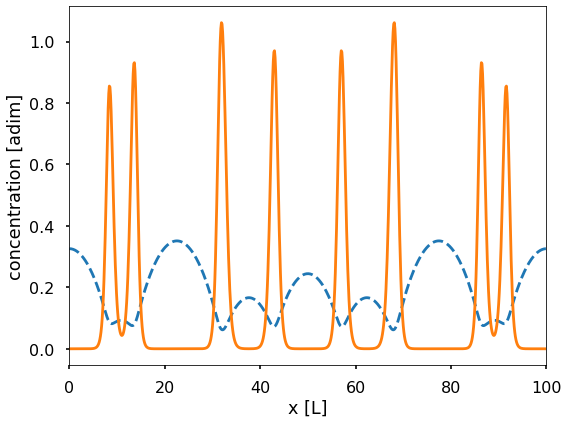

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

# Plotting
ax.plot(x_values, u_values_deg1[time-1], '--', label='U')
ax.plot(x_values, v_values_deg1[time-1], label='V')

# Setting the xy-labels
plt.xlabel('x [L]')
plt.ylabel('concentration [adim]')
plt.xlim(x_values.min(), x_values.max())

plt.tight_layout()
plt.show()

## Visualizando o padrão no tempo

Baseado na Figura 4 do artigo. Note que é necessário mudar os parâmetros e o tempo de simulação para coincidir.

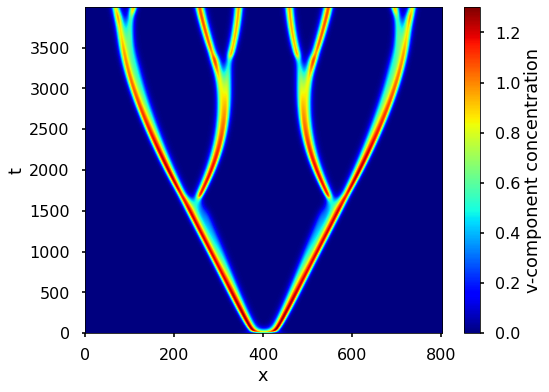

In [16]:
fig = plt.figure(figsize=(8, 6))
Vplot = np.array(v_values_deg1)
p = plt.imshow(Vplot, origin="lower", aspect='auto', cmap='jet')
clb = plt.colorbar(p, label="v-component concentration")
plt.xlabel('x')
plt.ylabel('t')
plt.show()